In [1]:
# Core imports needed for grading - DO NOT MODIFY THIS CELL

# packages

import os
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import folium

    
import geopandas as gpd
import rasterio as rio
import xarray as xr
import rioxarray as rxr
from shapely.geometry import mapping
import hydrofunctions as hf
import numpy.ma as ma
from rasterio.plot import plotting_extent
import rasterstats as rs
from shapely.geometry import box

%matplotlib inline

In [2]:
# set up paths to data

# Download data and set working directory
os.chdir(os.path.join(et.io.HOME, 
                      'earth-analytics', 
                      'data'))

# LA spreading grounds shapefiles
shape_spread_path = os.path.join("capstone",
                                 "la-spreading-grounds",
                                 "Spreading_Grounds_Feature_Layer.shp")                                 
shape_spread_data = gpd.read_file(shape_spread_path)

#LA catchment areas shapefiles
shape_catchment_path = os.path.join("capstone",
                                    "la-catchment-areas",
                                    "Los_Angeles_County_Catchment_Areas.shp")                                 
shape_catchment_data = gpd.read_file(shape_catchment_path)

#LA area region crop 

#Sentinel-2 data
sent_jan_2022_path = os.path.join("capstone", 
                                  "sent-jan-2022")

In [6]:
# Functions listed below 

def open_clean_bands(band_path,
                     crop_bound,
                     valid_range=None,
                     variable=None):
    
    """
    Open, clean, and crop a file into an xarray DataArray.

    Parameters
    -----------
    band_path:string
        A path to the array to be opened
    crop_bound:geopandas GeoDataFrame
        A geopandas dataframe to be used to crop the raster data using rioxarray clip().
    valid_range:tuple (optional)
         A tuple of min and max range of values for the data. Default = None
     Variable: list
         A list of variables to be opened 

    Returns
    -----------

    band : xarray DataArray
        End result for a cropped xarray dataarray
    """

    crop_bound_box = [box(*crop_bound.bounds.loc[0])]

    try:
        band = rxr.open_rasterio(band_path,
                                 masked=True,
                                 variable=variable).rio.clip(
                                                        crop_bound_box,
                                                        crs=crop_bound.crs,
                                                        all_touched=True,
                                                        from_disk=True).squeeze()
    except:
        raise ValueError(
            "Oops - I couldn't clip your data. This may be due to a crs error.")

    # Only mask the data to the valid range if a valid range tuple is provided
    if valid_range is not None:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band

In [7]:
# # Function 2: Mask cloud bands and crop 

# def mask_crop_ndmi(all_band_paths,
#                   crop_bound, 
#                   pixel_qa_path,
#                   vals):
#     """Open Sentinel-2 bands, mask potential clouds, and calculate NDMI.

#     Parameters
#     -----------
#     all_band_paths : list
#         a list for the xarray objects (using specific bands)
#     crop_bound: gpd GeoDataFrame
#         A geopandas dataframe  to crop the raster data (rasterio)
#     pixel_qa_path: xarray DataArray
#         An xarray DataArray with pixel qa values
#     vals: list
#         A list of values needed to create the cloud mask


#     Returns
#     -----------
#     ndmi_mark : Xarray Dataset
#         a cropped and masked xarray object containing NDMI values
    
#     """
#     # open all bands
#     bands = []
#     for band_path in all_band_paths: 
#         band = open_clean_bands(
#             band_path=band_path,
#             crop_extent=crop_bound,
#             valid_range=(0, 10000))
#         bands.append(band)

    
#     # open and mask cloud layer
#     cl_mask =  (rxr.open_rasterio(pixel_qa_path[0], masked=True)
#                     .rio.clip(crop_bound.geometry, from_disk=True)
#                     .squeeze())
        
#     # final NVMI calcs 
#     ndmi_xr = (bands[1]-bands[0]) / (bands[1]+bands[0])
    
#     # apply cloud mask to NDMI
#     ndmi_mask = ndmi_xr.where(~cl_mask.isin(vals))
    
#     return ndmi_mask

In [ ]:
def calculate_ndmi(post_precip_bands,
                    pre_precip_bands):

    """
    inputs
    -------
    
    post_precip_bands: 
        Numpy array of normalized burn ratio for near infrared bands post-fire
        

    prefire_nbr: Numpy array
        Numpy array of normalized burn ratio for near infrared bands pre-fire
    
    return
    --------
    dnbr: 
        Normalized difference in normalized burn ratio
        
    """


    # Calculate ndvi of pre and post fire 
    postfire_ndvi = (post_fire_bands[0]-post_fire_bands[3])/(
                    post_fire_bands[0]+post_fire_bands[3])

    prefire_ndvi = (pre_fire_bands[0]-pre_fire_bands[3])/(
                    pre_fire_bands[0]+pre_fire_bands[3])

    # calculate ndvi
    
    ndvi = prefire_ndvi - postfire_ndvi

    return ndvi

In [8]:
# Create a map for LA County Metro as the basemap
m = folium.Map(location=[34.0875, -118.2130])

# Display map
m

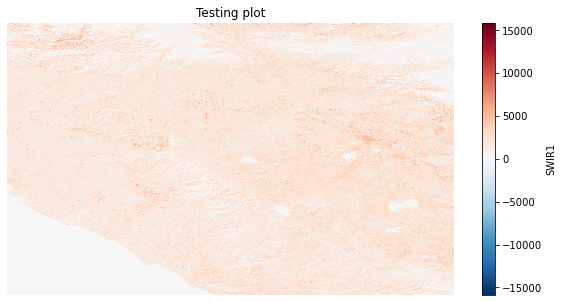

In [24]:
# test bands for a single site 

# both bands 
ndmi_bands = ["HLS.S30.T11SMT.2022003T183749.v2.0.B08.tif",
             "HLS.S30.T11SMT.2022003T183749.v2.0.B11.tif"]

#band 8
test_tif_8 = os.path.join("capstone",
                          "sent-jan-2022",
                        "HLS.S30.T11SMT.2022003T183749.v2.0.B08.tif")

#band 11
test_tif_11 = os.path.join("capstone", 
                           "sent-jan-2022",
                        "HLS.S30.T11SMT.2022003T183749.v2.0.B11.tif")

#create rasters for bands 8 and 11
test_rxr_8 = rxr.open_rasterio(test_tif_8,masked=True).squeeze()


cleaned_sent_8 = open_clean_bands(test_tif_8,
                                crop_bound = shape_catchment_data,
                                  valid_range = (0,10000))

test_rxr_11 = rxr.open_rasterio(test_tif_11,masked=True).squeeze()

cleaned_sent_11 = open_clean_bands(test_tif_11,
                                crop_bound = shape_catchment_data,
                                valid_range = (0,10000))

# test single band raster plot 
f, ax = plt.subplots(figsize=(10,5))
test_rxr_11.plot.imshow()
ax.set(title="Testing plot")

ax.set_axis_off()
plt.show()

# ep.plot_bands(pre_post_stack,
#               scale=False,
#               cmap='Greys',
#               title="Lidar Digital Terrain Model")
# plt.show()

In [ ]:
# Create loop to process a sample Sentinel-2 view 

#Determine path to test Sentinel-2  data
sent_path = os.path.join(sent_jan_2022_path,
                    "HLS.S30.T11SMT.2022003T183749.v2.0*")

sent_pre_post_scenes = glob(sent_path)

print(os.path.join(sent_path))
                                       

#for loop to process bands w/ function
sent_dict = {} 

# loop for each site to get bands
for site_file in sent_pre_post_scenes:
    all_dirs = glob(os.path.join(site_file, "*B0[2-5]*"))
    site_name = os.path.basename(os.path.normpath(site_file[-27:]))
    print("Working through",site_name)
    

    #loop to open clean bands in each directory
    sent_list = []
    for adir in all_dirs:
        cleaned_sent = open_clean_bands(adir,
                                           crop_bound = crop_bound,
                                            valid_range = (0,10000))
        sent_list.append(cleaned_sent)
        print(sent_list)

#     #Stack cleaned bands into one
#     pre_post_stack = xr.concat(sent_list, dim="band")      
    

#     #Add stacked bands to dict
#     sent_dict[site_name] = pre_post_stack

#     # test RGB plot
#     ep.plot_rgb(sent_dict[site_name],
#                 rgb=[2,1,0],
#                 title = "Test Plot")
